## Clustering Stars into Galaxies
To progress with analysis of the universe, the task is now to identify galaxies and separate the stars which belong to those galaxies. To start off, let's identify all of the stars that are not part of our local galaxy.

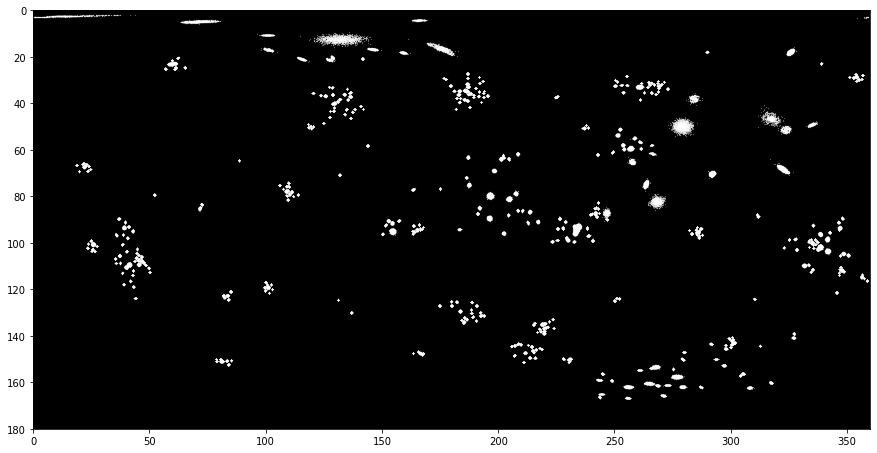

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

datapath = 'Sim Data (Clusters=1000, Seed=588)' # all of the data is within a folder in this .ipynb file's directory
stardata = pd.read_csv(datapath + '/Star Data.txt', delimiter=' ')    # read the data from the .txt file into a dataframe

equats = stardata['Equatorial']    # get the equatorial positions of all of the stars
polars = stardata['Polar']     # get the polar positions of all of the stars
parallax = stardata['Parallax']    # get the parallax of the stars

# now we need the indexes of stars with small/no parallax angles - distant stars!
indexes = [i for i, x in enumerate(parallax) if x <= 0.007] # this is a distance of about ~150pc
# now to populate new lists with all of the equatorial/polar angles of stars that litte/no some parallax
equats = [equats[i] for i in indexes]  
polars = [polars[i] for i in indexes]

# now lets plot these distant stars!
fig = plt.figure(figsize=(15, 15))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(equats, polars, s=0.02, c='w')  # plot small-ish dots, all white in colour
ax.set_xlim([0, 360]) # we go 0->360 degrees equatorially
ax.set_ylim([0, 180]) # we go 0->180 degrees along the poles
ax.invert_yaxis()  # the data is set up so that polar angle of 0 is at the top, so we need to flip the axis
ax.set_facecolor('k')   # space has a black background, duh
ax.set_aspect(1)    # makes it so that the figure is twice as wide as it is tall - no stretching!
plt.show()   # now, finally show the figure

We can see lots and lots of distant galaxies! If we're to do anything with them, though, we'll need to identify and separate galaxies, obtaining all of the stars from each particular galaxy in the process. When I encountered this problem for the first time, my choice was to manually draw ellipses around each cluster that I deemed to be a galaxy and, using the equation of an ellipse, determine all of the stars which satisfied being inside an ellipse. I then saved the star data to a separate file for each galaxy. This proved tedious as I'm sure you can imagine! When I first did this problem, I had to look at about ~50 or so galaxies -- in this picture above there are over 500! Surely there is a better way?

There is! Enter clustering: algorithms to detect clusters of points - this is perfect for our use in identifying galaxies in terms of clusters of resolved stars. There are a multitude of clustering algorithms, each built around an ideal use-case. What's the ideal method for our purposes here? We have to find an algorithm that can suitably meet the criteria:

1. Operate very quickly; there are over 500 galaxies each with around 1000 stars each, which is over five hundred thousand data points!
2. Successfully cluster points that are in elliptical/circular distributions, and irregularly sized. This immediately removes K-means clustering (often cited as the fastest algorithm) from the pool of potential algorithms, since it doesn't do too well with irregularly sized ellipses. 
3. Ideally already implemented within a python package (to make my job easier)

As a start, the DBScan method seems to be a suitable algorithm. The 'DB' in the name stands for density-based which is a good start - galaxies are quite literally an overdensity of stars so a method which looks for overdensities of points could be promising. Let's implement this to start. 

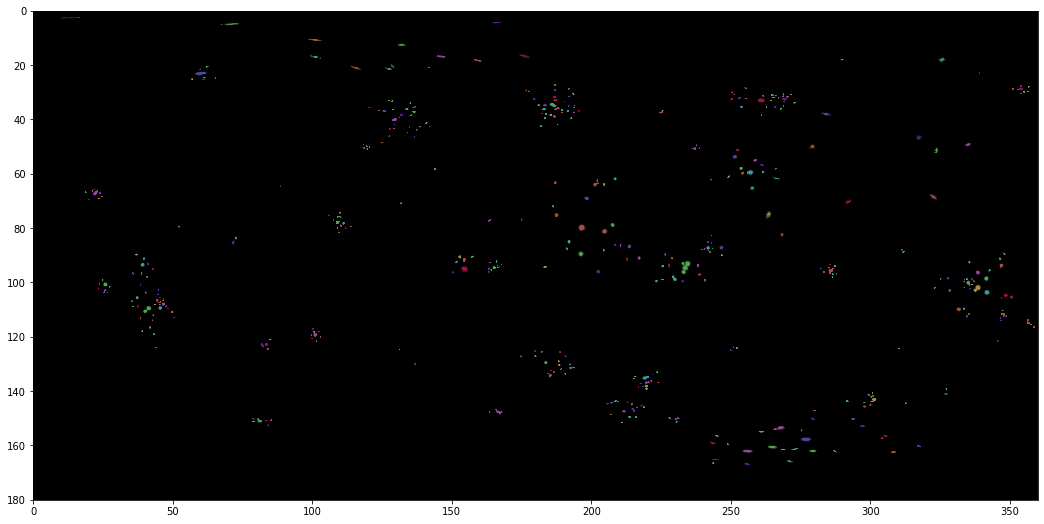

In [2]:
from sklearn import cluster
import numpy as np

# first, lets define the points for clustering in a suitable format. the clustering algorithm needs 'n' points, 
# where each point has a coordinate [x, y]. So our final array should look like: array = [[x1,y1], [x2,y2], ...]
coords = np.ndarray((len(equats), 2))  # set up an empty array of the correct length and dimension (Nx2)
for i, equat in enumerate(equats):
    coords[i] = [equat, polars[i]] # populate each element of the array with [x, y]

# now let's cluster the data. I won't get into too much detail, but if you want to know why I chose these
# parameters, I'd suggest looking up the documentation and cross-referencing these values against the param descriptions
clustering = cluster.DBSCAN(eps=0.3, min_samples=40, n_jobs=-1).fit(coords)

# now let's define some colours to display the different clusters in. 
colours = ['#ffe396', '#ffa1a1', '#a2ffa1', '#91f2ef', '#f196ff',
          '#ffa96b', '#94ffbf', '#9c9fff', '#ff6390', '#b570ff']

# the labels in this context correspond to which cluster it is. For n clusters, there will be n distinct labels which
# are all integers: 0, 1, 2, ..., n. Each point in 'coords' will have a label (and hence a cluster) assigned to it
labels = clustering.labels_ 

fig, ax = plt.subplots(figsize=(18, 9))   # now let's plot the clustering to see how we've done

for clust in range(0, max(labels) + 1):
    # want to go to max(labels) + 1, since labels starts at 0 & goes up to n, and range() starts at 0 & goes to n-1
    colour = colours[clust%len(colours)] # cycle through the colours
    Xk = coords[labels == clust] # get the 
    ax.scatter(Xk[:, 0], Xk[:, 1], alpha=0.8, c=colour, s=0.02, linewidths=0)
    
# the next scatter call plots white points for the stars that werent assigned to galaxies
ax.scatter(coords[labels == -1, 0], coords[labels == -1, 1], c="w", alpha=0.3, s=0.02, linewidths=0) 

ax.set_ylim(0, 180); ax.invert_yaxis()
ax.set_xlim(0, 360)
ax.set_facecolor('k')
fig.savefig('dbscan.png', dpi=1500) # i want to save this so that I can zoom in!
plt.show()

In the above picture, different colours represent different clusters. I know it's a bit small but I hope you can see that it looks chaotic and almost like sprinkles in some places -- this is good! That means that it's identifying different galaxies that are pretty close together. But alas, in some places it doesn't hold up:

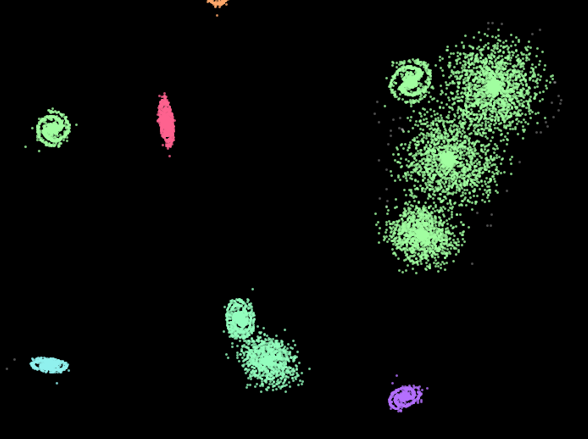

[Position ~= (240, 90)] We can see that it's thought that a region that is actually four galaxies (on the top right) is only one! Similarly, at the bottom, it's thought that two galaxies are actually one.
Fortunately, there is a slightly better method for this application: HDBscan! (the H is for hierarchical)
The details don't really matter, but the tl;dr is that it can automatically change the density of clustered points that it identifies. Let's implement this algorithm and see if it's any better.

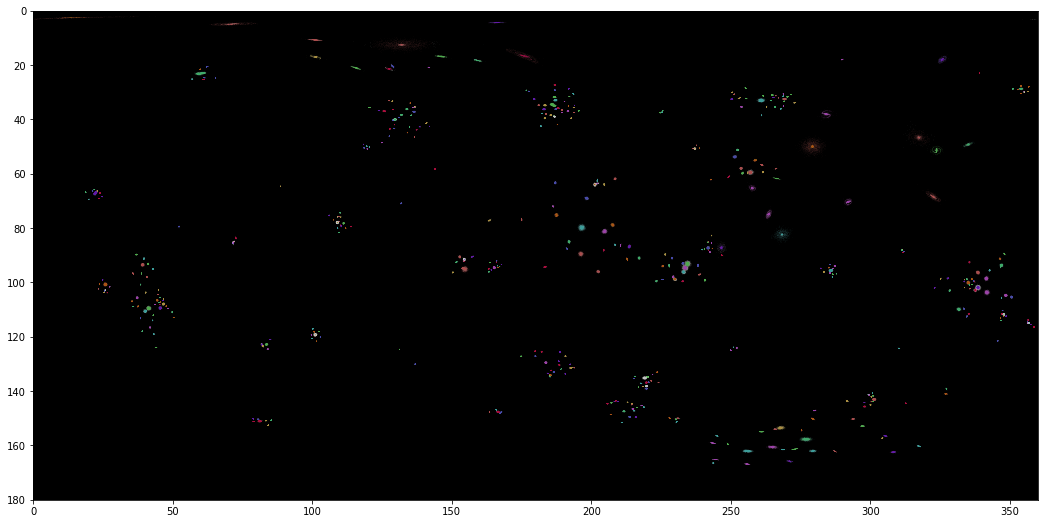

In [3]:
import hdbscan

# much of this code block is identical to the one before, so I'm going to be slack with the commenting
clustering = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=500).fit(coords) # want the smallest galaxy to have 500 stars
labels = clustering.labels_

fig, ax = plt.subplots(figsize=(18, 9))

for clust in range(0, max(labels) + 1):
    colour = colours[clust%len(colours)]
    Xk = coords[labels == clust]
    ax.scatter(Xk[:, 0], Xk[:, 1], alpha=0.8, c=colour, s=0.02, linewidths=0)
    
ax.scatter(coords[labels == -1, 0], coords[labels == -1, 1], s=0.02, c='w', linewidths=0)
ax.set_ylim(0, 180); ax.invert_yaxis(); ax.set_xlim(0, 360); ax.set_facecolor('k')
fig.savefig('hdbscan.png', dpi=1500)
plt.show()

Now, let's look at the same region as earlier to see how HDBScan clusters differently:

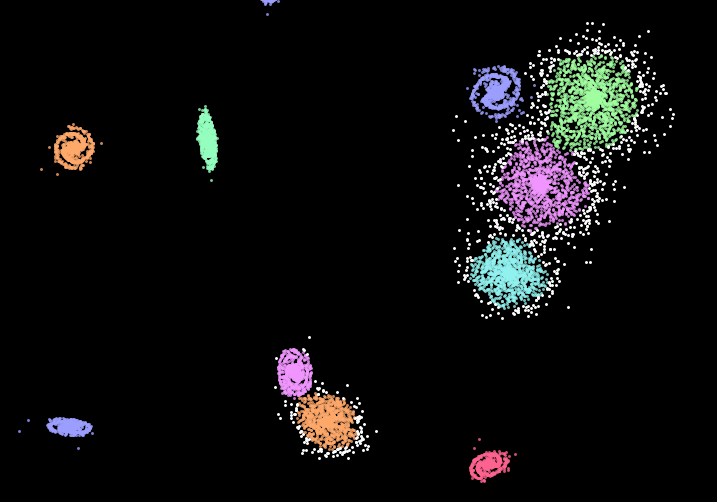

Clearly it's not perfect; there are more stars that aren't assigned to a galaxy than before (noise). With that said, it is now less likely for a star to be falsely assigned to a galaxy, which I believe is a much bigger positive than the 'fewer stars' negative. We can still do science with a galaxy when we don't have the entire population of stars, but it becomes incredibly hard to do it with completely false stars. 

Now, my preferred method of continuing is by separating the population of each galaxy into their own respective files. I'm sure that there are other (perhaps more efficient) methods of doing science with the results of the clustering, but this method is conceptually very easy to rationalise. To do this, I'll get all of the `stardata` rows corresponding to stars in each respective galaxy, and then write that data to a new file. <a id='save_galaxies'></a>

In [4]:
for clust in range(0, max(labels) + 1):
    indices = np.where(labels == clust)  # gets the indices of this galaxy's stars with respect to the stardata struct
    data = stardata.iloc[indices] # find the stars corresponding to the found indices
    
    Xk = coords[labels == clust] # get the positions of all of the stars in the galaxy
    xcenter = np.mean(Xk[:, 0]); ycenter = np.mean(Xk[:, 1]) # rough center points of each galaxy
    
    # now, I want to name the clusters like "X{equat}-Y{polar}-N{population}":
    clustername = 'X'+"%05.1f"%xcenter +'-Y'+"%05.1f"%ycenter+'-N'+str(len(Xk)) # generates cluster name
    # finally, write the data to a file defined by clustername
    data.to_csv(datapath + f'/Star Clusters/{clustername}.txt', index=None, sep=' ')    

## Identifying Galaxy Clusters
Now, it might be a good idea to identify the galaxy clusters for galaxies with resolved stars. First, I am going to get the positions and velocities of the centers of each galaxy so that I can treat them as a single object in space. I'm collecting the velocities as well, as we can assume that the galaxies are moving (mostly) as a function of distance and so we will effectively have another dimension with which we can constrain the clusters. 

In [5]:
positions = np.ndarray((max(labels), 3))
names = np.ndarray((max(labels)), dtype=object)

for clust in range(0, max(labels)):
    indices = np.where(labels == clust)  # gets the indices of this galaxy's stars with respect to the stardata struct
    data = stardata.iloc[indices] # find the stars corresponding to the found indices
    
    Xk = coords[labels == clust] # get the positions of all of the stars in the galaxy
    xcenter = np.mean(Xk[:, 0]); ycenter = np.mean(Xk[:, 1]) # rough center points of each galaxy
    meanvel = np.mean(data['RadialVelocity']) # get the mean velocity of the stars within the galaxy
    positions[clust] = [xcenter, ycenter, meanvel]
    # now, I want to name the clusters like "X{equat}-Y{polar}-N{population}":
    clustername = 'X'+"%05.1f"%xcenter +'-Y'+"%05.1f"%ycenter+'-N'+str(len(Xk)) # generates cluster name
    names[clust] = clustername

Now, let's plot it to see how it looks. 

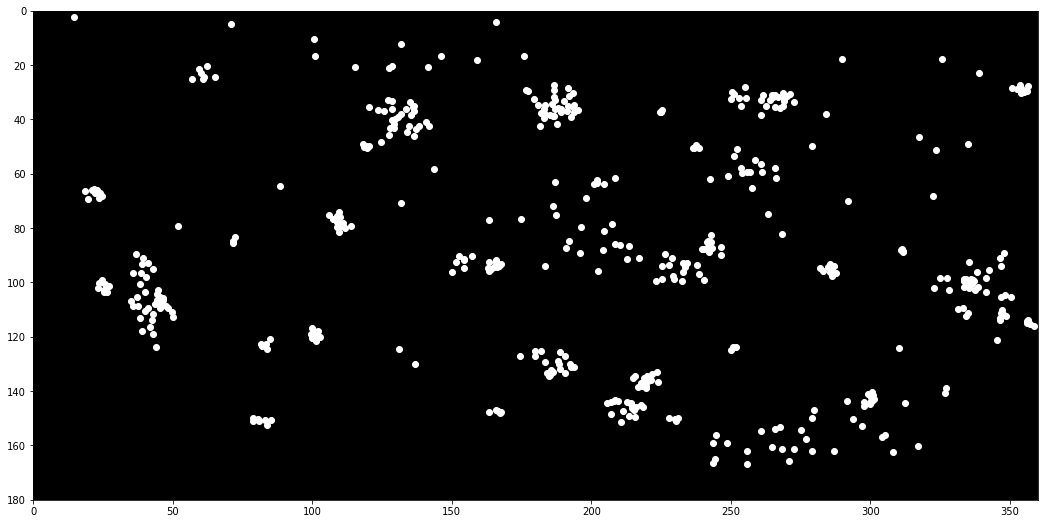

In [6]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.scatter(positions[:, 0], positions[:, 1], c='w')
ax.set_ylim(0, 180); ax.set_xlim(0, 360)
ax.set_facecolor('k')
ax.invert_yaxis()

Since there is a mix of sparesely and densly packed clusters, it would help our clustering algorithm to now add the extra dimension of velocity.

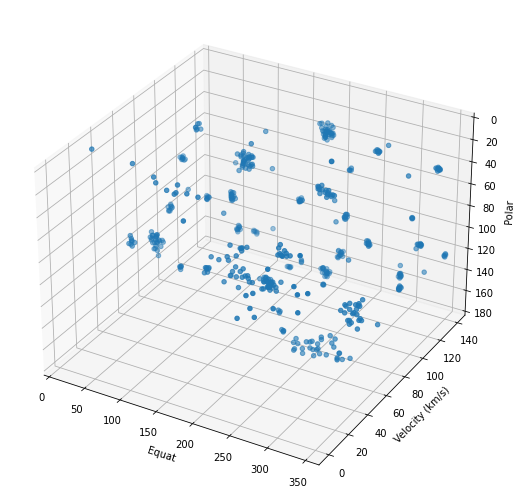

In [7]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(positions[:, 0], positions[:, 2], positions[:, 1])
ax.set_xlim(0, 360); ax.set_zlim(0, 180); ax.invert_zaxis()
ax.set_xlabel("Equat"); ax.set_zlabel("Polar"); ax.set_ylabel("Velocity (km/s)");

This extra dimension really seems to help separate galaxies, especially those that were previously overlapping. Now to actually start clustering the galaxies!

In [8]:
# much of this code block is identical to the one before, so I'm going to be slack with the commenting
closeclusters = hdbscan.HDBSCAN().fit(positions) # it seems to cluster optimally with no set parameters
labels = closeclusters.labels_

Now of course, time to plot the results to see if the clustering was successful. 

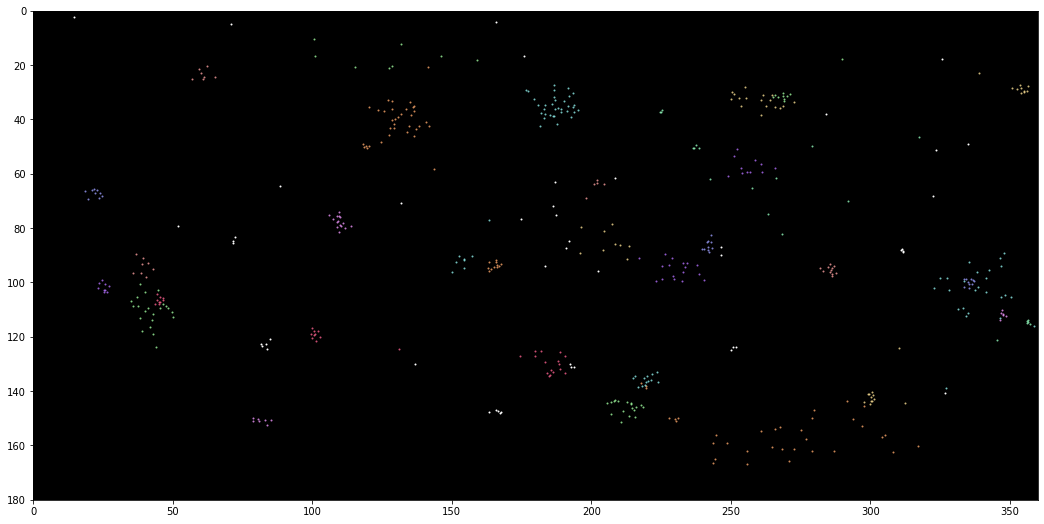

In [9]:
fig, ax = plt.subplots(figsize=(18, 9))

for clust in range(0, max(labels) + 1):
    colour = colours[clust%len(colours)]
    Xk = positions[labels == clust]
    ax.scatter(Xk[:, 0], Xk[:, 1], alpha=0.8, c=colour, s=4, linewidths=0)
    
ax.scatter(positions[labels == -1, 0], positions[labels == -1, 1], s=4, c='w', linewidths=0)
ax.set_ylim(0, 180); ax.invert_yaxis(); ax.set_xlim(0, 360); ax.set_facecolor('k')
fig.savefig('hdbscanClose.png', dpi=1500)
plt.show()

This seems pretty good for the most part. I can see a few points where it seems to fail, but the majority of clusters are well identified. Since there are a decent number of well constrained clusters, we can just ignore the badly fit ones later  on (with the justification of noisy data) and still arrive at a good result. Now, I'm going to save the galaxy *names* to a file for each cluster. 

In [10]:
for clust in range(0, max(labels) + 1):
    Xk = positions[labels == clust] # get the positions of all of the galaxies in the cluster
    xcenter = np.mean(Xk[:, 0]); ycenter = np.mean(Xk[:, 1]) # rough center points of each galaxy
    
    # now, I want to name the clusters like "GC-X{equat}-Y{polar}-N{population}":
    clustername = 'GC-X'+"%05.1f"%xcenter +'-Y'+"%05.1f"%ycenter+'-N'+str(len(Xk)) # generates cluster name
    galaxnames = names[labels == clust] # get the names of the galaxies within this cluster
    # finally, write the data to a file defined by clustername
    with open(datapath + f'/Close Galaxy Clusters/{clustername}.txt', 'w') as file: # open/create this file...
        for name in galaxnames: # for each galaxy in the cluster...
            file.write(str(name)+'\n') # ...write the galaxy name, and then end the line

And we're done for now!

## Finding Distant Galaxy Clusters
Now, I'm going to do a very similar process but with the very distant galaxies that don't have resolved stars. As before, I'll plot their distribution in the sky:

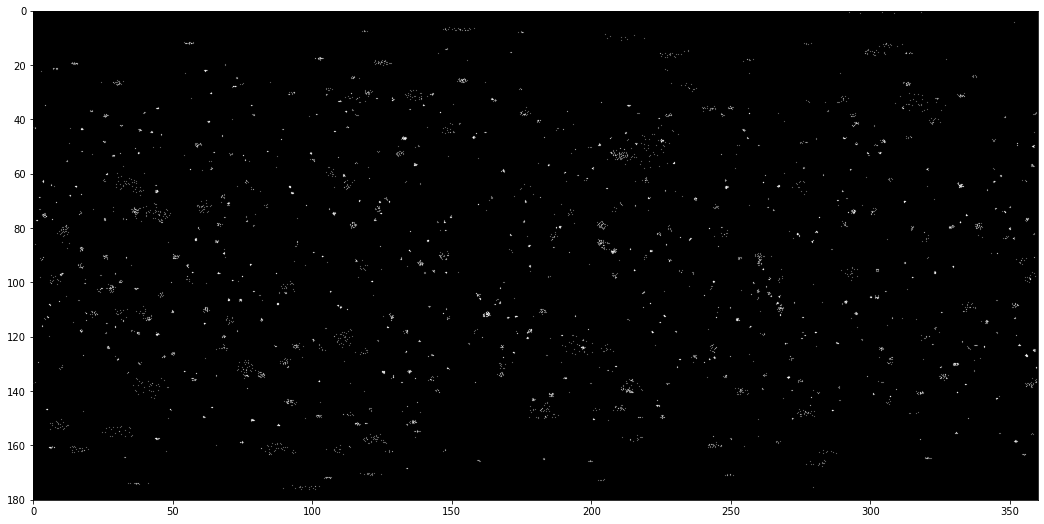

In [11]:
distantdata = pd.read_csv(datapath + '/Distant Galaxy Data.txt', delimiter=' ')

distantequats = distantdata['Equatorial']    # get the equatorial positions of all of the distant galaxies
distantpolars = distantdata['Polar']     # get the polar positions of all of the distant galaxies

# now lets plot these distant stars!
fig, ax = plt.subplots(figsize=(18, 9))
ax.scatter(distantequats, distantpolars, s=0.02, c='w')
ax.set_xlim([0, 360]); ax.set_ylim([0, 180]); ax.invert_yaxis() 
ax.set_facecolor('k')
plt.show()   # now, finally show the figure

There's a lot going on there! We can see hundreds of distant galaxy clusters. Now we should check if HDBScan can accurately identify the clusters. 
I'm only going to consider clusters of 5 or more galaxy members, because if we're trying to infer the physics of galaxy clusters, we want a large enough sample of galaxies within that cluster (otherwise our error bars would be massive!). With these, it's going to be a bit tricky as there are so many clusters overlapping each other. Thankfully as before, we can add an extra dimension to our clustering algorithm. Since (we can assume that) all of the galaxies are moving away or towards us as a function of distance, we can essentially add a third dimension with a velocity component. The result?

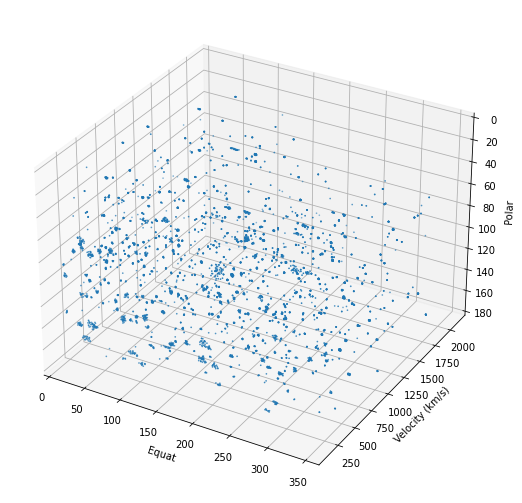

In [12]:
distantvels = distantdata['RadialVelocity']  # import the velocity data

fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(distantequats, distantvels, distantpolars, s=0.5)
ax.set_xlim(0, 360); ax.set_zlim(0, 180); ax.invert_zaxis()
ax.set_xlabel("Equat"); ax.set_zlabel("Polar"); ax.set_ylabel("Velocity (km/s)");

Nicely separated galaxy clusters. Now to call the clustering algorithm...

In [13]:
distantcoords = np.ndarray((len(distantequats), 3))  # set up an empty array of the correct length and dimension (Nx3)
for i, equat in enumerate(distantequats):
    distantcoords[i] = [equat, distantpolars[i], distantvels[i]] # populate each element of the array with [x, y, v]

# much of this code block is identical to the one before, so I'm going to be slack with the commenting
distantclusters = hdbscan.HDBSCAN().fit(distantcoords)
labels = distantclusters.labels_

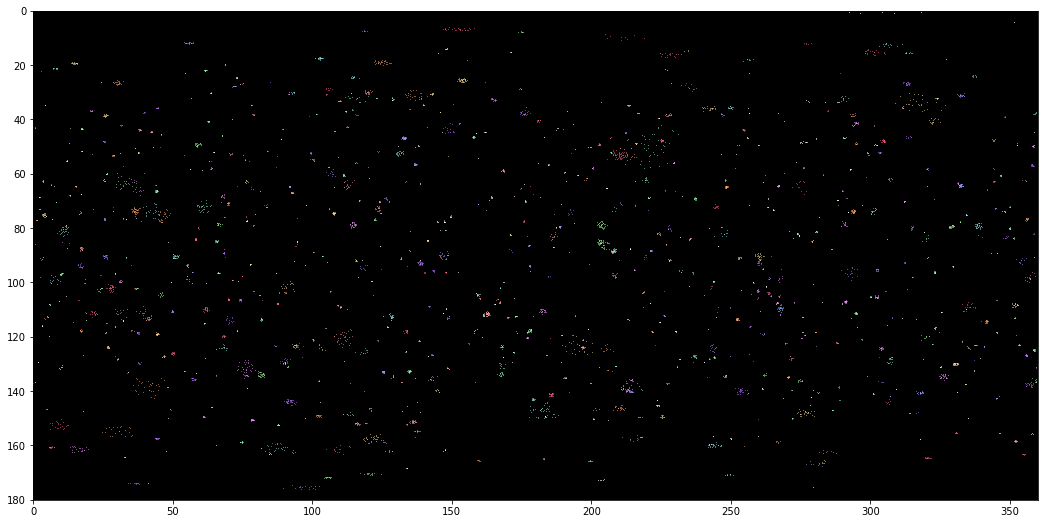

In [14]:
fig, ax = plt.subplots(figsize=(18, 9))

for clust in range(0, max(labels) + 1):
    colour = colours[clust%len(colours)]
    Xk = distantcoords[labels == clust]
    ax.scatter(Xk[:, 0], Xk[:, 1], alpha=0.8, c=colour, s=0.5, linewidths=0)
    
ax.scatter(distantcoords[labels == -1, 0], distantcoords[labels == -1, 1], s=0.5, c='w', linewidths=0)
ax.set_ylim(0, 180); ax.invert_yaxis()
ax.set_xlim(0, 360)
ax.set_facecolor('k')
fig.savefig('hdbscanDistant.png', dpi=1500)
plt.show()

Some excellent results here. Now, I am going to save each cluster to a file (with all of the data of the component distant galaxies), similar to how I did in the [section where I saved the star data of galaxies](#save_galaxies):

In [15]:
for clust in range(0, max(labels) + 1):
    indices = np.where(labels == clust)  # gets the indices of this cluster's galaxies with respect to distantdata
    data = distantdata.iloc[indices] # find the galaxies corresponding to the found indices
    
    Xk = distantcoords[labels == clust] # get the positions of all of the stars in the cluster
    xcenter = np.mean(Xk[:, 0]); ycenter = np.mean(Xk[:, 1]) # rough center points of each cluster
    
    # now, I want to name the clusters like "DC-X{equat}-Y{polar}-N{population}":
    clustername = 'DC-X'+"%05.1f"%xcenter +'-Y'+"%05.1f"%ycenter+'-N'+str(len(Xk)) # generates cluster name
    # finally, write the data to a file defined by clustername
    data.to_csv(datapath + f'/Distant Galaxy Clusters/{clustername}.txt', index=None, sep=' ')    

And we're done! With this, we can now move onto studying the physics within each galaxy and each galaxy cluster.